## OMMI processing
- First run the code up to the registration for all files for an experiment
- Change directory to registered files and copy text files into here
- Then get ROIs from the condition that is expected to give strongest responses
- Use the same ROIs for all other conditions

### notes

- Consider multithreading extraction of time courses
- Registration throws index error when green frame is last in file

In [ ]:
import numpy as np
import tifffile as tf
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from scipy import signal
from roipoly import MultiRoi
import imregpoc
import mpld3
from skimage import feature
from skimage import draw

#mpld3.enable_notebook()  ## disable if no internet connection

def getROI(roi, im):
    data=np.zeros((len(im)))
    for i in range(len(im)):
        data[i]=ndimage.mean(im[i,:,:],labels=roi)
    return data

def AOIselector(imageIn):
    ### imagIn expected to be single frame###
    %matplotlib 
    plt.imshow(imageIn)
    plt.show()
    my_rois = MultiRoi(roi_names=['bulb1', 'bulb2'])
    %matplotlib inline

    BulbMask = my_rois.rois['bulb1'].get_mask(imageIn)
    BulbMask+=my_rois.rois['bulb2'].get_mask(imageIn)
    return BulbMask


In [ ]:
#path='D:/Cedric/OMMI/FastedGlucose/805/Glucose/*.txt'
#path ='D:/Cedric/OMMI/Glutamate blockers/ID790/Glucose/*.txt'
path='C:/Users/johnstonlab/Documents/Reged/Glucose/*.txt'
# D:\Cedric\OMMI\Glutamate blockers\ID790\Fasted

files=glob.glob(path)

In [ ]:
## check file names are sequenctial
fileNums=[]
for data in files:
    fileNums.append(int(data[-7:-4]))

plt.plot(fileNums)
del fileNums, data

### Register data to green channel
- Only run the first of these cells once per experiment. The first cell gets the reference image to which everything else will be registered
- Once this has been executed change teh path to the location of the registered files and copy all the text files, required for accurate splitting of channels

In [ ]:
## Get the reference image to which everything will be registered
im = tf.imread(files[1][:-4]+'0001.tif') ## specify the file path for this seperately as it will be the same across all sessions

# padding parameters for phase correlation
padsize=512
stY=int((padsize-im.shape[1])/2)
enY=(padsize-im.shape[1])-stY
stX=int((padsize-im.shape[2])/2)
enX=(padsize-im.shape[2])-stX

## get reference image
txt = np.loadtxt(files[0])
channel=txt[:,1];
Chan1=np.argwhere(channel==1);
redfileLen = len(np.argwhere(channel==1))
fileLength=round((redfileLen/100)-0.5)*100  ## round down to nearest 100
print('number of frames in image data is', redfileLen, 'so rounding to', fileLength)
RefImage=np.pad(np.squeeze(im[Chan1[0],:,:]),((stY,enY),(stX,enX)), 'constant',constant_values=(0))
plt.imshow(im[1]);
#del txt, channel, Chan1, padsize

In [ ]:
# # register

for file in files:
#file = files[0]    
    txt = np.loadtxt(file)
    channel=txt[:,1];
    Chan1=np.argwhere(channel==1);

    im = tf.imread(file[:-4]+'0001.tif') # get corresponding tiff file
    imPadded = np.zeros((len(im),512,512)) ## padded movie for phase correlation
    #imPadded0= np.zeros((len(im),512,512))
    Im1reg=np.zeros((len(Chan1),512,512))
    for j in range(len(im)):  ## pad the whole movie
        imPadded[j,:,:]=np.pad(np.squeeze(im[j,:,:]),((stY,enY),(stX,enX)), 'edge')#,constant_values=(0))# padimage(im[j,:,:])
    for i in range(len(Chan1)):
        Im1=np.squeeze(imPadded[Chan1[i],:,:])
        regParams=imregpoc.imregpoc(Im1,RefImage)
        if(i==len(Chan1)-1):   ## to catch last green channel and correct the remaining files
            #print('stop')
            for k in range(int(Chan1[i]),len(imPadded)):
                imPadded[k,:,:]=regParams.Warp_4dof(imPadded[k,:,:],regParams.getParam());
                #print(k)
        else:
            #print(i)
            for k in range(int(Chan1[i]),int(Chan1[i+1])):
                imPadded[k,:,:]=regParams.Warp_4dof(imPadded[k,:,:],regParams.getParam());


    #channel1Stack=np.concatenate(Channel1)
    tf.imwrite('Reged/'+file[-19:-4]+'0001.tif',imPadded[:,stY:im.shape[1]+stY,stX:im.shape[2]+stX].astype('uint16'))

# Demix channels and odours
- get -150 to +550 frames from each valve opening
- calcuate and display the response images for each odour and channel

In [ ]:
def demixChan(chan):
    Channel=[]
    for file in files:
        txt = np.loadtxt(file)
        im = tf.imread(file[:-4]+'0001.tif') # get corresponding tiff file
        channel=txt[:,1];

        Chan0=np.argwhere(channel==chan);# get locations of frames that correspond to channel 0
        Im0=np.zeros((len(Chan0),im.shape[1],im.shape[2]),dtype='uint16') ## assign memroy

        Valve0=[]
        for i in range(len(Chan0)):
            if Chan0[i]==len(im):
                break
            else:
                Im0[i,:,:]=im[Chan0[i],:,:]
                Valve0.append(txt[Chan0[i],3])
        im0keep=Im0[(np.argmax(Valve0)-150):(np.argmax(Valve0)+(fileLength-230)),:,:] #550
        Channel.append(im0keep)
    return np.concatenate(Channel)

In [ ]:
Red = demixChan(0)
segmentLen = int(Red.shape[0]/len(files))
print(segmentLen)

In [ ]:
Blue = demixChan(2)
Blue.shape

In [ ]:
# input the order in whihc the odours were applied
order=[2,1,4,3,2,3,1,4,2,1,4,3,1,3,4,2,1,4,2,3]*3
print(order)
odourOrder=np.asarray(order)

del order

## Seperate odours for each channel and get response images

In [ ]:
def getResponseImages(BckCorrectedMovie,St,En):
    Responses1=[]
    Responses2=[]
    Responses3=[]
    Responses4=[]
    k=0
   # print(len(BckCorrectedMovie)/500)
    for i in range(len(files)): #0,len(BckCorrectedMovie),fileLength):  # change back to 700 for green channel every 400  
        stim=BckCorrectedMovie[(i*segmentLen):(i*segmentLen)+(segmentLen),:,:]
        baseline=np.mean(stim[0:100,:,:],axis=0)
        response=np.mean(stim[St:En,:,:],axis=0)
        if odourOrder[k]==1:
            Responses1.append(response-baseline)
        elif odourOrder[k]==2:
            Responses2.append(response-baseline)
        elif odourOrder[k]==3:
            Responses3.append(response-baseline)
        elif odourOrder[k]==4:
            Responses4.append(response-baseline)
        k+=1
    ResponseStack1=np.stack(Responses1, axis=0)
    ResponseStack2=np.stack(Responses2, axis=0)
    ResponseStack3=np.stack(Responses3, axis=0)
    ResponseStack4=np.stack(Responses4, axis=0)
    responses=[ResponseStack1,ResponseStack2,ResponseStack3,ResponseStack4]
    return responses

In [ ]:
redData=getResponseImages(Red,250,520)
blueData=getResponseImages(Blue,160,190)



## Plot highpass filtered response images

In [ ]:
odoursR = []
odoursB=[]

for st in redData:
    a = ndimage.gaussian_filter(np.mean(st, axis=0),2)
    b = ndimage.gaussian_filter(a,8)
    odoursR.append((a-b)*-1)   ## invert red channel

for st in blueData:
    a = ndimage.gaussian_filter(np.mean(st, axis=0),1)
    b = ndimage.gaussian_filter(a,7)
    odoursB.append(a-b)
    
fig, axs=plt.subplots(2,4,figsize=(12,8), constrained_layout=True,sharey=True,sharex=True)

for i in range(4):
    axs[0][i].imshow(odoursR[i])
    
for i in range(4):
    axs[1][i].imshow(odoursB[i]);#/im[0,:,:])

del i, a, b, st

## Define Glomeruli as ROIs
- using Detemrinant of Hessian (blob_doh) or Laplacian of Gaussian (blob_log) to detect blobs corresponding to active glomeruli
- define roi as 2 pixels smaller than this to ensure the centre contributes most
- define background as annulus with extent 10 pix bigger than glomeuli, excluding areas that contain other active glomeruli

In [ ]:
# mask the bulbs   optional, to undo rerun the above cell
mask=AOIselector(odoursB[1]); ## use the image that looks the worst

for r in odoursR:
    r*=mask
for r in odoursB:
    r*=mask

fig, axs = plt.subplots(1,2, figsize=(12,8))
axs[0].imshow(odoursR[0]);
axs[1].imshow(odoursB[0]);


In [ ]:
## first tune these parameters
thr=7
glomSize=[5,9]
##
od=2

Redblob=odoursR[od].astype('float64')
Blueblob=odoursB[od].astype('float64')
rr=feature.blob_log(Redblob,glomSize[0],glomSize[1],threshold=thr,overlap=0.2)
bb=feature.blob_log(Blueblob,glomSize[0],glomSize[1],threshold=thr,overlap=0.2)
imSize=Redblob.shape
combined =rr

for b in bb:
    d=rr-b
    d=abs(d[:,0])+abs(d[:,1]) ## get distances between two circles centres
    if np.min(d) > b[2]+4:
        combined=np.append(combined,b[None,:],axis=0) ## if centres overlap they are the same so don't append

fig, axs = plt.subplots(1,2, figsize=(12,8))
axs[0].imshow(Redblob)
axs[1].imshow(Blueblob)

for blob in combined:
    y,x,r = blob
    c=plt.Circle((x,y),r,linewidth=2,color='r', fill=False)
    d=plt.Circle((x,y),r,linewidth=2,color='b', fill=False)
    axs[0].add_patch(c)
    axs[1].add_patch(d)

del c,combined,bb,rr,Redblob,Blueblob,od, y,r,x, blob

In [ ]:
## now get all rois for all odours
i = 0
for re in odoursR:
    Redblob=re.astype('float64')
    rbs = feature.blob_log(Redblob,glomSize[0],glomSize[1],threshold=thr,overlap=0.2)
    if i ==0:
        Combined = rbs
    for rb in rbs:
        d=Combined-rb
        d=abs(d[:,0])+abs(d[:,1]) ## get distances between two circles centres
        if np.min(d) > rb[2]+2:
            Combined=np.append(Combined,rb[None,:],axis=0) ## if centres overlap they are the same so don't append
    i+=1
    
for bl in odoursB:
    Blueblob=bl.astype('float64')
    blbs = feature.blob_log(Blueblob,glomSize[0],glomSize[1],threshold=thr,overlap=0.2)
    for bb in blbs:
        d=Combined-bb
        d=abs(d[:,0])+abs(d[:,1]) ## get distances between two circles centres
        if np.min(d) > bb[2]+2:
            Combined=np.append(Combined,bb[None,:],axis=0) ## if centres overlap they are the same so don't append

            
## convert to a mask for timecourse extraction
ROIs = np.zeros((len(Combined), imSize[0],imSize[1]))
k=1
for roi in Combined:
    xx, yy =draw.circle(roi[0], roi[1], roi[2], shape=imSize )
    ROIs[k-1,xx,yy]=1
    k+=1
    
## plotting
fig, axs = plt.subplots(1,2, figsize=(12,8))
axs[0].imshow(Redblob)
axs[1].imshow(Blueblob)

for blob in Combined:
    y,x,r = blob
    c=plt.Circle((x,y),r,linewidth=2,color='r', fill=False)
    d=plt.Circle((x,y),r,linewidth=2,color='b', fill=False)
    axs[0].add_patch(c)
    axs[1].add_patch(d)

del c,Redblob,Blueblob, y,r,x, blob

In [ ]:
## generate background for each ROI
BckROIs = np.zeros((len(Combined),imSize[0],imSize[1]))
fullROIs= np.zeros((imSize[0],imSize[1]))
k=1
for roi in Combined:
    xx, yy =draw.circle(roi[0], roi[1], roi[2]+2, shape=imSize )
    fullROIs[xx,yy]=1
    xx, yy =draw.circle(roi[0], roi[1], roi[2]+10, shape=imSize )
    BckROIs[k-1,xx,yy]=1
    k+=1
i=0

for bRoi in BckROIs:
    BckROIs[i,:,:]=(bRoi-fullROIs)>0
    i+=1

print(len(BckROIs), " ROIs detected")
del bRoi, fullROIs, k,roi 

## Extract timecourses of each channel and its background
- this takes a bit

In [ ]:
## get surround timecourses of red channel
RedSurround=np.zeros((len(Red),len(BckROIs)))
for i in range(len(BckROIs)):
    RedSurround[:,i]=getROI(BckROIs[i],Red)

In [ ]:
## get Centre timecourses of red channel
RedCentre=np.zeros((len(Red),len(BckROIs)))
for i in range(len(ROIs)):
    RedCentre[:,i]=getROI(ROIs[i],Red)

In [ ]:
## get Surround timecourses of blue channel
BlueSurround=np.zeros((len(Red),len(BckROIs)))
for i in range(len(ROIs)):
    BlueSurround[:,i]=getROI(BckROIs[i],Blue)

In [ ]:
## get Centre timecourses of red channel
BlueCentre=np.zeros((len(Red),len(BckROIs)))
for i in range(len(ROIs)):
    BlueCentre[:,i]=getROI(ROIs[i],Blue)

## Save centres, surrounds and ROI masks

In [ ]:
tf.imwrite('RedGlucose.tif',RedCentre)
tf.imwrite('BlueGlucose.tif',BlueCentre)
tf.imwrite('RedGlucoseSur.tif',RedSurround)
tf.imwrite('BlueGlucoseSur.tif',BlueSurround)

#tf.imwrite('Centres.tif', ROIs)
#tf.imwrite('Surrounds.tif', BckROIs)

# after here you will want to load in the processed data and plot however you want

In [ ]:
RedCorGluc = tf.imread('RedGlucose.tif')
BlueCorGluc = tf.imread('BlueGlucose.tif')

In [ ]:
BackgroundWeight = 0.7
RedCorrected=RedCentre-(RedSurround*BackgroundWeight)
BlueCorrected = BlueCentre-(BlueSurround*BackgroundWeight)


## Get odour responses and plot some data

### Todo
- plot ROI and surround with data beside it, panel for each odour
- plot individuals in light colour 1 point and ave/med in 2 point darker
- Something to summarise all odours
- slider to move through glomeruli

In [241]:
def getOdourTimeCourse(ImTCdata):

    Responses1=[]
    Responses2=[]
    Responses3=[]
    Responses4=[]
    k=0
    for i in range(0,len(ImTCdata),segmentLen):  
        stim=ImTCdata[i:i+segmentLen,:]
        baseline=np.mean(stim[0:149,:],axis=0)

        if odourOrder[k]==1:
            Responses1.append((stim-baseline[None,:])/baseline[None,:])
        elif odourOrder[k]==2:
            Responses2.append((stim-baseline[None,:])/baseline[None,:])
        elif odourOrder[k]==3:
            Responses3.append((stim-baseline[None,:])/baseline[None,:])
        elif odourOrder[k]==4:
            Responses4.append((stim-baseline[None,:])/baseline[None,:])
        k+=1

    B1=np.stack(Responses1[0:5], axis=0)
    B2=np.stack(Responses1[5:10], axis=0)
    B3=np.stack(Responses1[10:15], axis=0)
    Od1Bs=np.concatenate((B1,B2,B3),axis=1)# (blueResponses1[10:15], axis=1)

    B1=np.stack(Responses2[0:5], axis=0)
    B2=np.stack(Responses2[5:10], axis=0)
    B3=np.stack(Responses2[10:15], axis=0)
    Od2Bs=np.concatenate((B1,B2,B3),axis=1)# (blueResponses1[10:15], axis=1)

    B1=np.stack(Responses3[0:5], axis=0)
    B2=np.stack(Responses3[5:10], axis=0)
    B3=np.stack(Responses3[10:15], axis=0)
    Od3Bs=np.concatenate((B1,B2,B3),axis=1)# (blueResponses1[10:15], axis=1)

    B1=np.stack(Responses4[0:5], axis=0)
    B2=np.stack(Responses4[5:10], axis=0)
    B3=np.stack(Responses4[10:15], axis=0)
    Od4Bs=np.concatenate((B1,B2,B3),axis=1)# (blueResponses1[10:15], axis=1)
    OdourTCs=[Od1Bs,Od2Bs,Od3Bs,Od4Bs]
    return OdourTCs

In [246]:
## Load data and seperate into odours
Red1 = getOdourTimeCourse(tf.imread('RedFasted.tif'))
Red1 = getOdourTimeCourse(tf.imread('RedDrugs.tif'))
Red1 = getOdourTimeCourse(tf.imread('RedGlucose.tif'))

Blue1 = getOdourTimeCourse(tf.imread('BlueFasted.tif'))
Blue2 = getOdourTimeCourse(tf.imread('BlueDrugs.tif'))
Blue3 = getOdourTimeCourse(tf.imread('BlueGlucose.tif'))

ROIs = tf.imread('Centres.tif')
Surrounds = tf.imread('Surrounds.tif')

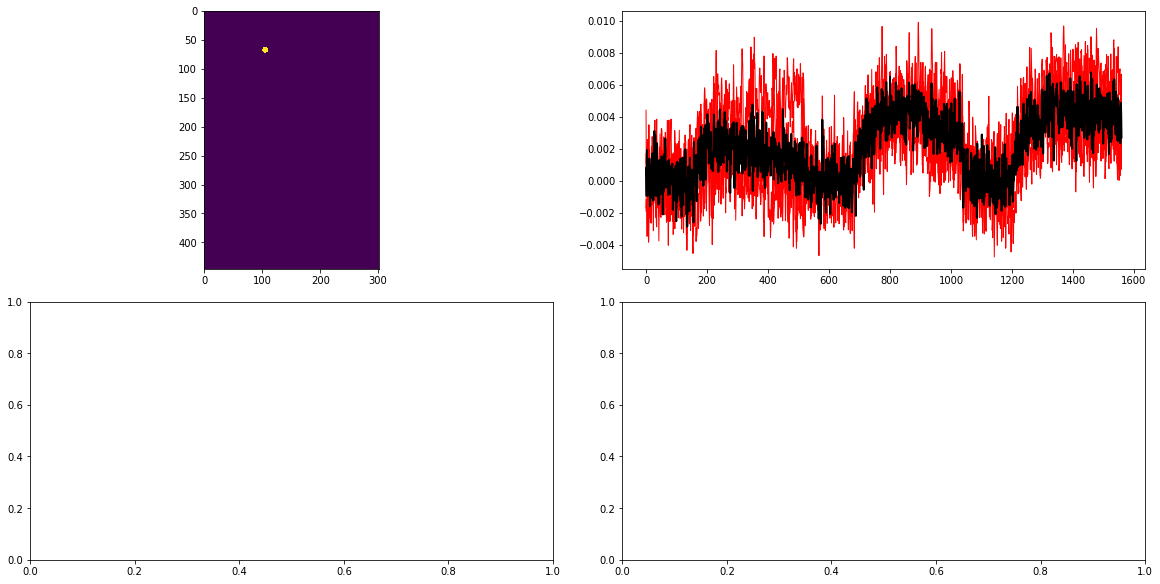

In [286]:
r = 21
od = 2
fig1, axs = plt.subplots(2,2, figsize=(16,8), constrained_layout=True)

axs[0][0].imshow(ROIs[r]);
#axs[0].imshow(Surrounds[0]);

for i in range(5):
    axs[0][1].plot(signal.savgol_filter(Red1[od][i,:,r],9,4,axis=0)*-1, color='r',linewidth=1);
axs[0][1].plot(np.mean(Red1[od][:,:,r],axis=0)*-1, color='k',linewidth=2)




In [ ]:
od=0


AveReds=np.mean(RedOdData[od],axis=0)
AveBlues=np.mean(BlueOdData[od],axis=0)
#AveRDrug=np.mean(RedDrugs[od],axis=0)
#AveBDrug=np.mean(BlueDrugs[od],axis=0)

# # # to show the mean
AveReds=np.mean(AveReds,axis=1)
AveBlues=np.mean(AveBlues,axis=1)
# AveRDrug=np.mean(AveRDrug,axis=1)
# AveBDrug=np.mean(AveBDrug,axis=1)


#AveBlues=signal.savgol_filter(AveBlues,9,4,axis=0)
#AveBDrug=signal.savgol_filter(AveBDrug,9,4,axis=0)

#AveReds=signal.savgol_filter(AveReds,39,2,axis=0)
#AveRDrug=signal.savgol_filter(AveRDrug,39,2,axis=0)

In [ ]:
for ex in range(0,15):
    fig, ax=plt.subplots(2,1,figsize=(14,5), sharex=True)
    ax[0].plot(AveReds[:,ex]*-1, color='r')
   # ax[0].plot(AveRDrug[:,ex]*-1, color='y')
    ax[1].plot(AveBlues[:,ex], color='b')
   # ax[1].plot(AveBDrug[:,ex], color='y')
    
#     ax.plot(AveBlues[:,ex])
#     ax2=ax.twinx()

In [ ]:
fig, ax=plt.subplots(2,1,figsize=(14,5))
ax[0].plot(AveReds*-1, color='r')
#ax[0].plot(AveRDrug*-1, color='y')
ax[1].plot(AveBlues, color='b')
#ax[1].plot(AveBDrug, color='y')

In [ ]:
ex = 0
mpld3.disable_notebook()

for ex in range(55):
    fig, ax=plt.subplots(1,1,figsize=(14,5))
    ax.plot(AveReds[:,ex],color='r');
    ax.plot(AveRedBck[:,ex],color='b');
#ax2.plot(AveBlues[:,ex]);

# ax.plot(AveReds[:,ex+1]*-1,color='y');
#ax2 =ax.twinx() 
#ax2.plot(AveBlues[:,ex+1],color='y');